# Prompts

**Structured Prompts**:
- Frameworks like RSTCC, RICCE, etc.

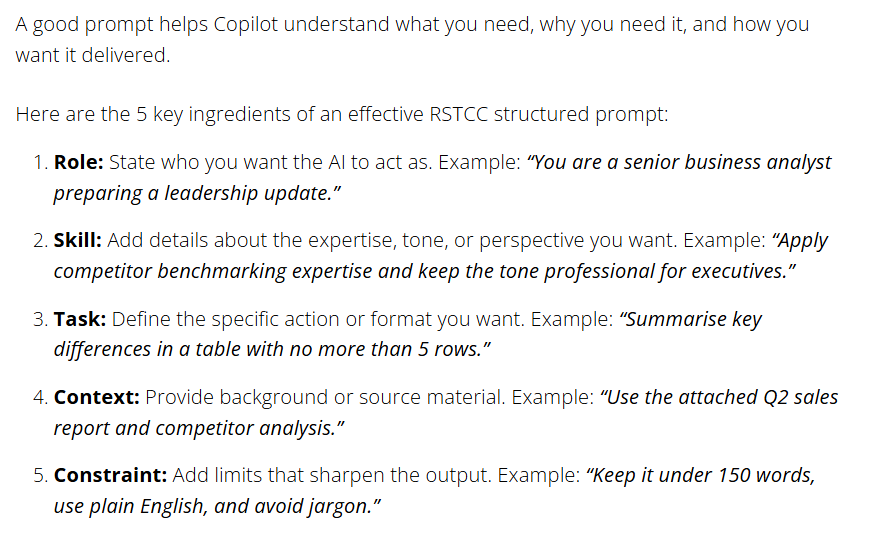


# Transformer from scratch

In [2]:
from transformers import AutoTokenizer
from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BertModel.from_pretrained(model_ckpt)
text = "Time flies like an arrow."
show(model, "bert", tokenizer, text, display_mode = 'light', layer = 0, head = 8)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\Evgeni Zorin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Evgeni Zorin\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

100%|██████████| 440473133/440473133 [00:13<00:00, 32105522.98B/s]
C:\Users\Evgeni Zorin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\bertviz\transformers_neuron_view\modeling_utils.py:482: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use cas

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
inputs = tokenizer(
    text, 
    return_tensors = 'pt', 
    add_special_tokens = False # exclude tokens like [CLS] and [SEP]
)
inputs.input_ids


tensor([[ 2051, 10029,  2066,  2019,  8612,  1012]])

In [4]:
from torch import nn
from transformers import AutoConfig

config = AutoConfig.from_pretrained(model_ckpt)
token_emb = nn.Embedding(config.vocab_size, config.hidden_size)
token_emb


Embedding(30522, 768)

In [5]:
inputs_embeds = token_emb(inputs.input_ids)
inputs_embeds.size()


torch.Size([1, 6, 768])

In [6]:
import torch
from math import sqrt

query = key = value = inputs_embeds
dim_k = key.size(-1)
scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
scores.size()

torch.Size([1, 6, 6])

In [7]:
import torch.nn.functional as F

weights = F.softmax(scores, dim=-1)
weights.sum(dim=-1)

attn_outputs = torch.bmm(weights, value)
attn_outputs.shape

torch.Size([1, 6, 768])

In [8]:
def scaled_dot_product_attention(query, key, value):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value)


class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)
    
    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(
            self.q(hidden_state), self.k(hidden_state), self.v(hidden_state)
        )
        return attn_outputs

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        x = self.output_linear(x)
        return x

multihead_attn = MultiHeadAttention(config)
attn_output = multihead_attn(inputs_embeds)
attn_output.size()


torch.Size([1, 6, 768])

In [9]:
from bertviz import head_view
from transformers import AutoModel

model = AutoModel.from_pretrained(model_ckpt, output_attentions=True)

sentence_a = "time flies like an arrow"
sentence_b = "fruit flies like a banana"

viz_inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt')
attention = model(**viz_inputs).attentions
sentence_b_start = (viz_inputs.token_type_ids == 0).sum(dim=1)
tokens = tokenizer.convert_ids_to_tokens(viz_inputs.input_ids[0])

head_view(attention, tokens, sentence_b_start, heads=[8])

ImportError: cannot import name 'ExecutableLocation' from 'tensorflow.python.distribute.cluster_resolver.kubernetes_cluster_resolver' (C:\Users\Evgeni Zorin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tensorflow\python\distribute\cluster_resolver\kubernetes_cluster_resolver.py)